## Objetivo do Notebook de Modelagem

Este notebook tem como objetivo desenvolver, avaliar e comparar modelos de Machine Learning para **previsão de churn de clientes**.

O foco principal é:
- Maximizar a capacidade de identificar clientes com risco de evasão
- Utilizar métricas adequadas para problemas desbalanceados
- Garantir interpretabilidade e robustez do modelo

Além do treinamento dos modelos, todo o experimento é **versionado e rastreado utilizando MLflow**, permitindo:
- Comparação sistemática entre modelos
- Registro de métricas, parâmetros e artefatos
- Reprodutibilidade dos experimentos


In [7]:
import kaggle
import pandas as pd
import matplotlib.pyplot as plt
import mlflow
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, recall_score, precision_recall_curve, average_precision_score
from pathlib import Path

DATA_DIR = (Path.cwd().parent / "data")
DATA_DIR.mkdir(parents=True, exist_ok=True)

kaggle.api.authenticate()
kaggle.api.dataset_download_files("radheshyamkollipara/bank-customer-churn", path=DATA_DIR, unzip=True)

mlflow.set_tracking_uri('http://127.0.0.1:5000/')
mlflow.set_experiment(experiment_id='1')

Dataset URL: https://www.kaggle.com/datasets/radheshyamkollipara/bank-customer-churn


<Experiment: artifact_location='mlflow-artifacts:/1', creation_time=1767182804274, experiment_id='1', last_update_time=1767182804274, lifecycle_stage='active', name='Churning', tags={'mlflow.experimentKind': 'custom_model_development'}>

In [8]:
df = pd.read_csv(DATA_DIR/'Customer-Churn-Records.csv')
df = df.drop(columns=["RowNumber","CustomerId","Surname",'Complain'])
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Satisfaction Score,Card Type,Point Earned
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,2,DIAMOND,464
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,3,DIAMOND,456
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,3,DIAMOND,377
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,5,GOLD,350
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,5,GOLD,425


## Preparação e Pré-processamento dos Dados

Antes da modelagem, realizamos as seguintes etapas:
- Separação entre variáveis numéricas e categóricas
- Codificação de variáveis categóricas
- Padronização quando necessário
- Divisão em conjuntos de treino e teste

Esse processo garante consistência e evita vazamento de dados.


In [9]:
def preprocessing():
    X = df.drop(columns=['Exited'])
    y = df['Exited']

    cat = X.select_dtypes(object).columns.to_list()
    num = X.select_dtypes([float,int]).columns.tolist()
    X[num] = X[num].astype('float64') #converter int pra float por causa do funcionamento do mlflow 

    X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, random_state=42, test_size=0.2, stratify=y)

    preprocessar = ColumnTransformer(
        transformers = [
            ("num", StandardScaler(), num),
            ("cat", OneHotEncoder(handle_unknown="ignore"), cat)
        ]
    )

    return X_treino, X_teste, y_treino, y_teste, preprocessar

X_treino, X_teste, y_treino, y_teste, preprocessar = preprocessing()

print("Taxa variavel resposta geral:", df['Exited'].mean())
print("Taxa variavel resposta treino:", y_treino.mean())
print("Taxa variavel resposta teste:", y_teste.mean())
print(X_treino.isna().sum())

Taxa variavel resposta geral: 0.2038
Taxa variavel resposta treino: 0.20375
Taxa variavel resposta teste: 0.204
CreditScore           0
Geography             0
Gender                0
Age                   0
Tenure                0
Balance               0
NumOfProducts         0
HasCrCard             0
IsActiveMember        0
EstimatedSalary       0
Satisfaction Score    0
Card Type             0
Point Earned          0
dtype: int64


## Treinamento dos Modelos

Nesta seção, diferentes algoritmos são treinados e comparados.

O objetivo é avaliar:
- Capacidade preditiva
- Estabilidade
- Desempenho em métricas relevantes para churn


In [10]:
models = {
    'DecisionTree': {
        'model': DecisionTreeClassifier(random_state=42, class_weight='balanced'),
        'params': {
            'criterion': ['gini', 'entropy'],
            'max_depth': [3, 4, 5],
            'min_samples_leaf': [2, 5, 10, 20],
            'max_features': ['sqrt', 'log2',None]
        }
    },
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200, 300, 400],
            'max_depth': [3, 4, 5],
            'min_samples_leaf': [2, 5, 10, 20],
            'max_features': ['sqrt', 'log2'],
            'class_weight': ['balanced_subsample',"balanced"]
        }
    },
    'XGBClassifier':{
        'model': XGBClassifier(random_state=42, objective='binary:logistic', eval_metric='auc', scale_pos_weight=4),
        'params': {
            'n_estimators': [300, 500],
            'max_depth': [3, 4],
            'learning_rate': [0.03, 0.1],
            'subsample': [0.8, 1.0],
            'colsample_bytree': [0.8, 1.0]
        }
    }
}


## Treinamento dos Modelos com Pipeline, GridSearch e MLflow

Nesta célula é executado o fluxo completo de treinamento dos modelos.

Para cada algoritmo:
- Um pipeline é criado combinando pré-processamento e modelo
- Os hiperparâmetros são otimizados via GridSearchCV
- O foco da avaliação é o **recall**, priorizando a identificação de clientes em risco de churn
- Todo o experimento é rastreado com **MLflow**, registrando parâmetros, métricas e o modelo final

Ao final, as importâncias das features são analisadas e os resultados de cada modelo são armazenados para comparação.


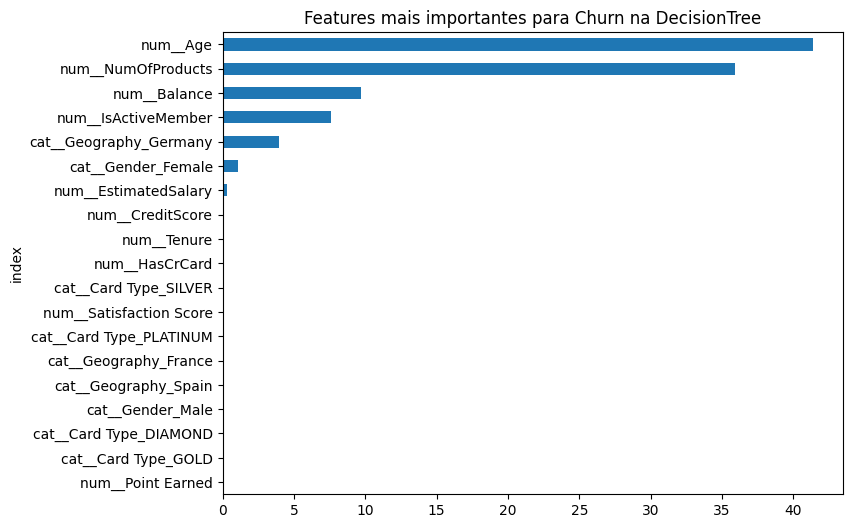

🏃 View run DecisionTree at: http://127.0.0.1:5000/#/experiments/1/runs/629a27d48f3d4b049c479a7f002bbf1e
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1
DecisionTree melhores parâmetros: {'criterion': 'entropy', 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 20}


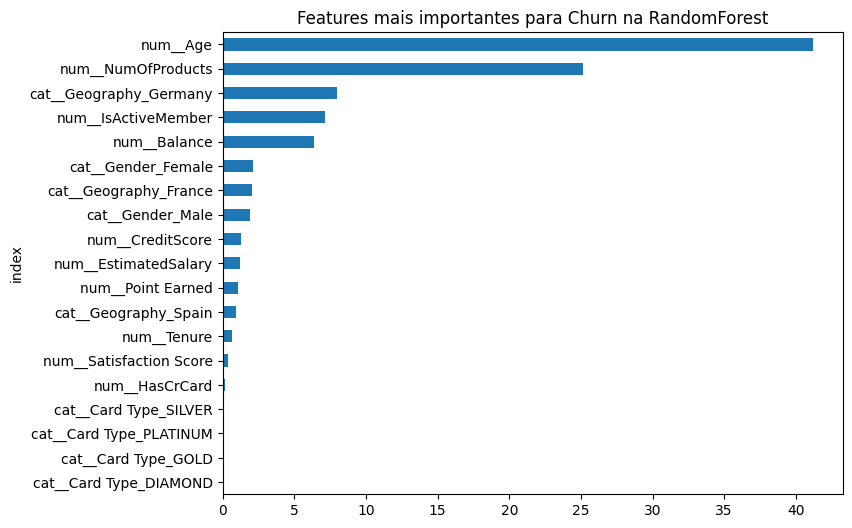

🏃 View run RandomForest at: http://127.0.0.1:5000/#/experiments/1/runs/92664f9ebf83430b90017f41e05b970b
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1
RandomForest melhores parâmetros: {'class_weight': 'balanced', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 20, 'n_estimators': 300}


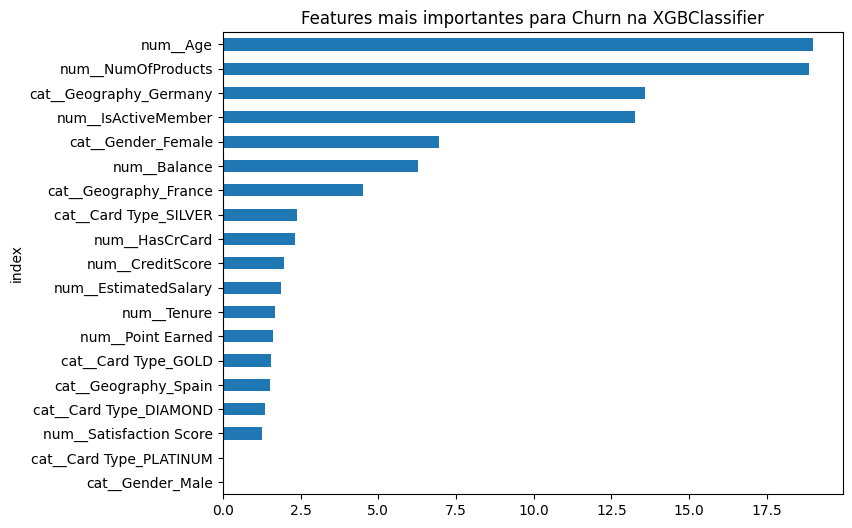

🏃 View run XGBClassifier at: http://127.0.0.1:5000/#/experiments/1/runs/bcdb00a7d61645278a6d59e2eff71acb
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1
XGBClassifier melhores parâmetros: {'colsample_bytree': 1.0, 'learning_rate': 0.03, 'max_depth': 3, 'n_estimators': 300, 'subsample': 1.0}


In [ ]:
def build_pipeline():
    resultados = []
    for nome, config in models.items():
        pipeline = Pipeline(
            steps=[
                ("preprocessar", preprocessar),
                ("model", GridSearchCV(config['model'], config['params'], cv=5, scoring='recall', n_jobs=4))
                ])
        
        with mlflow.start_run(run_name=(nome)) as run:
            mlflow.sklearn.autolog()
            run_id = run.info.run_id

            pipeline.fit(X_treino,y_treino)

            model = pipeline.named_steps["model"].best_estimator_
            bestparamsmodel = pipeline.named_steps["model"].best_params_
            feature_names = pipeline.named_steps["preprocessar"].get_feature_names_out()

            importancia = pd.Series(model.feature_importances_, index=feature_names).reset_index(name="importancia").sort_values("importancia")
            importancia.plot(kind="barh", x="index", y="importancia", legend=False, figsize=(8,6))
            plt.title(f"Features mais importantes para Churn na {nome}")
            plt.show()

        
        resultados.append({'nome': nome, 'model': model, 'pipeline': pipeline, 'features': feature_names,'id_run': run_id}) 
        print(f'{nome} melhores parâmetros: {bestparamsmodel}')

    return resultados

resultados = build_pipeline()

## Avaliação de Performance e Comparação entre Modelos

Devido ao desbalanceamento da variável alvo, métricas tradicionais como acurácia não são suficientes.

As principais métricas analisadas incluem:
- ROC AUC
- Precision-Recall AUC
- Recall para a classe positiva (churn)

Com os experimentos registrados no MLflow, é possível:
- Comparar métricas entre diferentes modelos
- Avaliar trade-offs entre performance e complexidade
- Escolher o modelo mais adequado para o problema de churn

🏃 View run DecisionTree at: http://127.0.0.1:5000/#/experiments/1/runs/629a27d48f3d4b049c479a7f002bbf1e
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1
            Estatística Treino DecisionTree:

              precision    recall  f1-score   support

   Não churn       0.91      0.84      0.87      6370
       Churn       0.52      0.68      0.59      1630

    accuracy                           0.81      8000
   macro avg       0.72      0.76      0.73      8000
weighted avg       0.83      0.81      0.82      8000

            Estatística Teste DecisionTree:

              precision    recall  f1-score   support

   Não churn       0.92      0.83      0.87      1592
       Churn       0.52      0.70      0.59       408

    accuracy                           0.81      2000
   macro avg       0.72      0.77      0.73      2000
weighted avg       0.83      0.81      0.82      2000



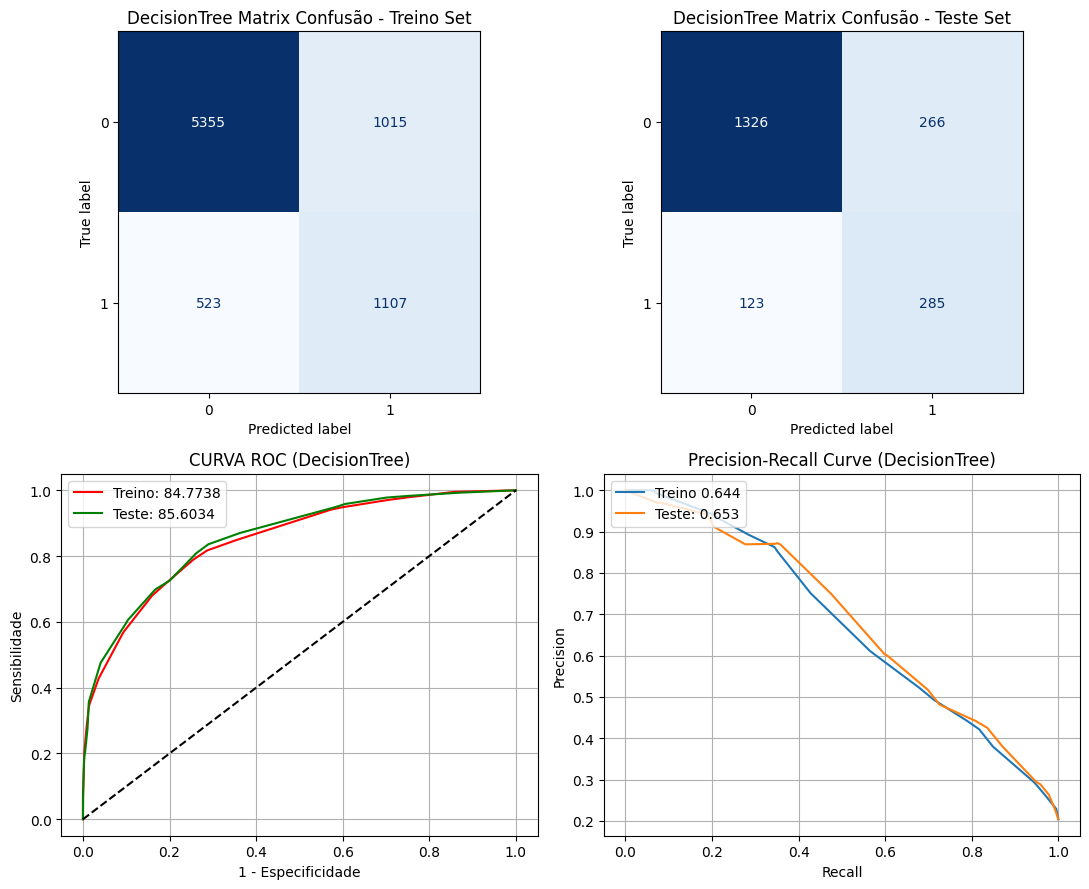

🏃 View run RandomForest at: http://127.0.0.1:5000/#/experiments/1/runs/92664f9ebf83430b90017f41e05b970b
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1
            Estatística Treino RandomForest:

              precision    recall  f1-score   support

   Não churn       0.93      0.81      0.86      6370
       Churn       0.50      0.76      0.60      1630

    accuracy                           0.80      8000
   macro avg       0.71      0.78      0.73      8000
weighted avg       0.84      0.80      0.81      8000

            Estatística Teste RandomForest:

              precision    recall  f1-score   support

   Não churn       0.93      0.79      0.85      1592
       Churn       0.49      0.77      0.60       408

    accuracy                           0.79      2000
   macro avg       0.71      0.78      0.73      2000
weighted avg       0.84      0.79      0.80      2000



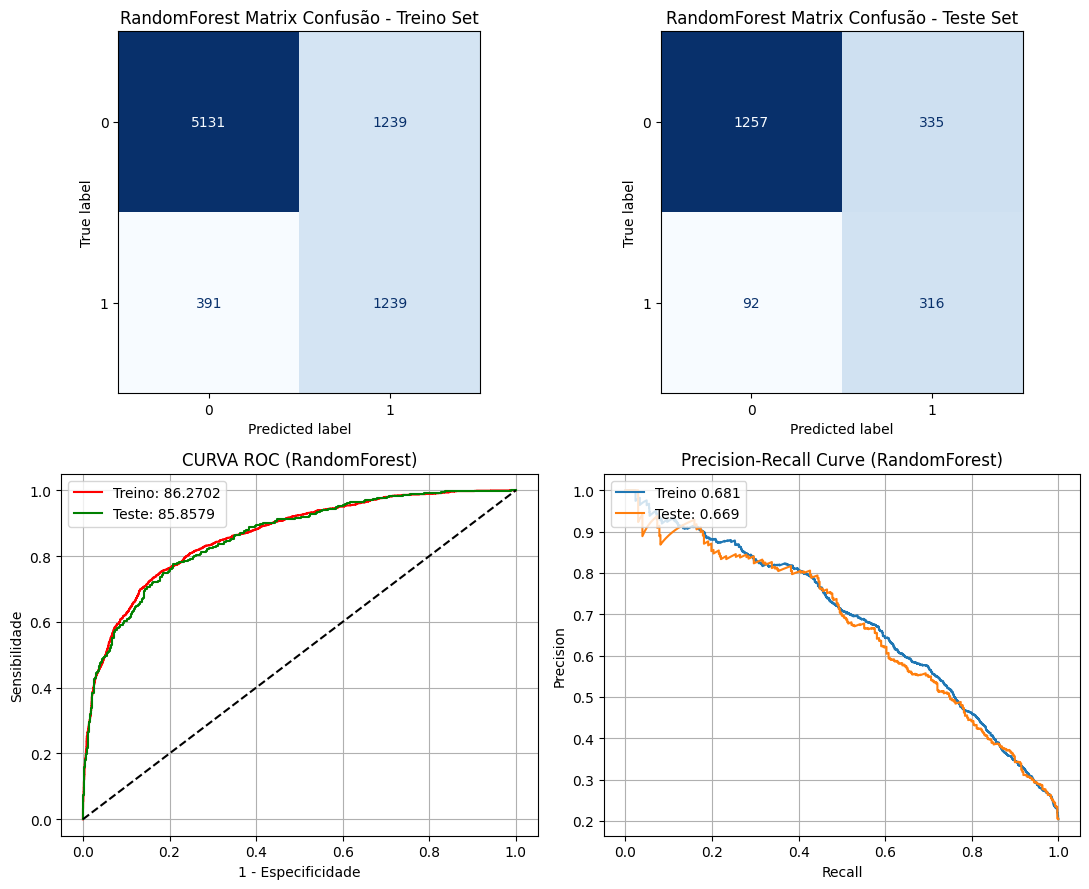

🏃 View run XGBClassifier at: http://127.0.0.1:5000/#/experiments/1/runs/bcdb00a7d61645278a6d59e2eff71acb
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1
            Estatística Treino XGBClassifier:

              precision    recall  f1-score   support

   Não churn       0.94      0.80      0.86      6370
       Churn       0.50      0.80      0.62      1630

    accuracy                           0.80      8000
   macro avg       0.72      0.80      0.74      8000
weighted avg       0.85      0.80      0.81      8000

            Estatística Teste XGBClassifier:

              precision    recall  f1-score   support

   Não churn       0.94      0.78      0.85      1592
       Churn       0.48      0.79      0.59       408

    accuracy                           0.78      2000
   macro avg       0.71      0.78      0.72      2000
weighted avg       0.84      0.78      0.80      2000



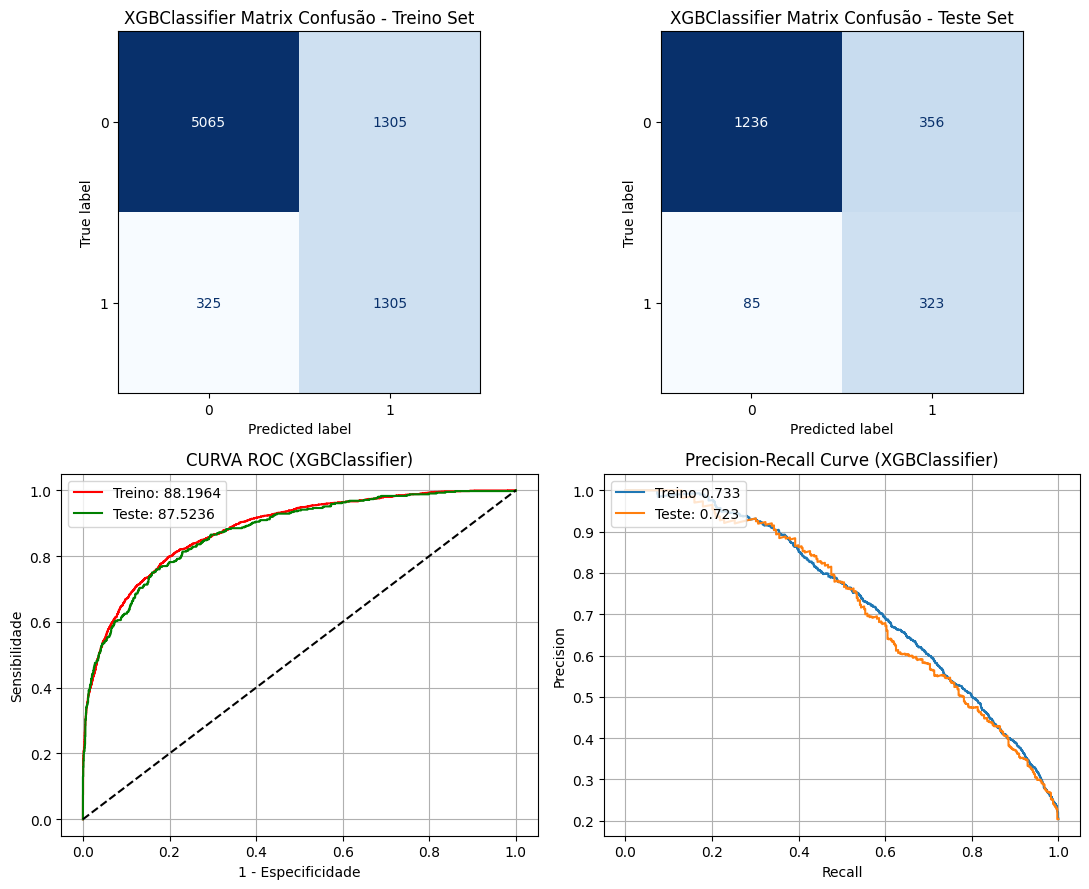

In [12]:
def get_performance(resultados):
   for resultado in resultados:
        
      nome = resultado['nome']
      pipeline = resultado['pipeline']
      id_run = resultado['id_run']
      
      with mlflow.start_run(run_id=id_run):
         y_treino_proba = pipeline.predict_proba(X_treino)[:,1]
         y_teste_proba = pipeline.predict_proba(X_teste)[:,1]

         precision, recall, threshold = precision_recall_curve(y_treino, y_treino_proba)
         precision = precision[:-1]
         recall = recall[:-1]

         target_recall = 0.70
         min_precision = 0.50
         bestthreshold = 0

         for p, r, t in zip(precision, recall, threshold):
            if r >= target_recall and p >= min_precision:
               bestthreshold = t
               break

         if bestthreshold == 0:
            best_f1 = 0
            for p, r, t in zip(precision, recall, threshold):
               if p + r > 0:
                     f1 = 2 * p * r / (p + r)
                     if f1 > best_f1:
                        best_f1 = f1
                        bestthreshold = t

         y_treino_predict = (y_treino_proba >= bestthreshold).astype(int)
         auc_treino = roc_auc_score(y_treino, y_treino_proba)
         roc_treino = roc_curve(y_treino, y_treino_proba)
         cr_treino = classification_report(y_treino, y_treino_predict, target_names=['Não churn','Churn'],zero_division=0)
         avg_treino = average_precision_score(y_treino, y_treino_proba)
         recall_treino = recall_score(y_treino, y_treino_predict)

         y_teste_predict = (y_teste_proba >= bestthreshold).astype(int)
         auc_teste = roc_auc_score(y_teste, y_teste_proba)
         roc_teste = roc_curve(y_teste, y_teste_proba)
         cr_teste = classification_report(y_teste, y_teste_predict, target_names=['Não churn','Churn'],zero_division=0)
         avg_teste = average_precision_score(y_teste, y_teste_proba)
         recall_teste = recall_score(y_teste, y_teste_predict)
         
         mlflow.log_metrics({
            "auc_treino": auc_treino,
            "auc_teste": auc_teste,
            "prc_treino": avg_treino,
            "prc_teste": avg_teste,
            "recall_treino": recall_treino,
            "recall_teste": recall_teste,
            "threshold": bestthreshold
         })

      prprecision_treino, prrecall_treino,_ = precision_recall_curve(y_treino, y_treino_proba)
      prprecision_teste, prrecall_teste,_ = precision_recall_curve(y_teste, y_teste_proba)
      
      print(f'            Estatística Treino {nome}:\n\n{cr_treino}')
      print(f'            Estatística Teste {nome}:\n\n{cr_teste}')
      
      cmtreino, cmteste = confusion_matrix(y_treino, y_treino_predict), confusion_matrix(y_teste, y_teste_predict)
      cmplottreino, cmplotteste = ConfusionMatrixDisplay(cmtreino, display_labels=[0,1]), ConfusionMatrixDisplay(cmteste, display_labels=[0,1])

      fig, axes = plt.subplots(2, 2, figsize=(11, 9))
      axes = axes.flatten()

      cmplottreino.plot(ax=axes[0], cmap="Blues", colorbar=False)
      axes[0].set_title(f"{nome} Matrix Confusão - Treino Set")
      cmplotteste.plot(ax=axes[1], cmap="Blues", colorbar=False)
      axes[1].set_title(f"{nome} Matrix Confusão - Teste Set")

      axes[2].set_title(f"CURVA ROC ({nome})")
      axes[2].plot(roc_treino[0], roc_treino[1], color='red')
      axes[2].plot(roc_teste[0], roc_teste[1], color='green')
      axes[2].plot([0,1], [0,1], color='black', linestyle= '--')
      axes[2].set_xlabel("1 - Especificidade")
      axes[2].set_ylabel("Sensibilidade")
      axes[2].legend([f"Treino: {100*auc_treino:.4f}", f"Teste: {100*auc_teste:.4f}"], loc='upper left')
      axes[2].grid(True)

      axes[3].set_title(f"Precision-Recall Curve ({nome})")
      axes[3].plot(prrecall_treino, prprecision_treino)
      axes[3].plot(prrecall_teste, prprecision_teste)
      axes[3].set_xlabel("Recall")
      axes[3].set_ylabel("Precision")
      axes[3].legend([f"Treino {avg_treino:.3f}",f"Teste: {avg_teste:.3f}"], loc='upper left')
      axes[3].grid(True)
      
      plt.tight_layout()
      plt.show()

get_performance(resultados)